In [3]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-6,-6,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.01,0.01,0.01,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.03,size=3)
real_disturbance = np.zeros(3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    traj = []
    for N in np.array([5,10,15]):

        quadrotor_linear = Quadrotor_linear()

        x_init = np.zeros(10)
        x_init[0]=drone[0]
        x_init[1]=drone[1]
        
        x_target = np.zeros(10)
        x_target[0] = goal[0]
        x_target[1] = goal[1]
        x_target[2] = goal[2]
        
        x_hat = x_init
        x_real = x_init
        d_hat=np.zeros((3,1))
        output = x_init
        
        L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
        A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
        
        inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
        x_intergoal=np.zeros(10)
        x_intergoal[:2]=inter_goal
        x_intergoal[2] = x_target[2]

        real_trajectory = {'x': [], 'y': [], 'z': []}
        est_trajectory = {'x': [], 'y': [], 'z': []}
        output_trajectory = {'x': [], 'y': [], 'z': []}
        
        d_hat_list=[]
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

        i = 0
        while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
            
            i += 1

            A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
            
            u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
            
            d_hat_list.append(d_hat)
            
            A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

            x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
            
            x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
            #print("x_error:",(x_real).flatten())
            print(i)
            print("x_real :",x_real.flatten())
            #print("\n")
            #print("ref:",x_ref,u_ref)
            
        A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
        print("***")

        while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.2 and i<=2000:
            i+=1
            
            u = mpc_control_stable(quadrotor_linear, 30, output.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


            if u is None:
                print("no solution")
                u=np.zeros((4,1))
            else:
                u = u.reshape(-1,1)

            est_trajectory['x'].append(x_hat[0])
            est_trajectory['y'].append(x_hat[1])
            est_trajectory['z'].append(x_hat[2])
            
            real_trajectory['x'].append(x_real[0])
            real_trajectory['y'].append(x_real[1])
            real_trajectory['z'].append(x_real[2])
            
            output_trajectory['x'].append(output[0])
            output_trajectory['y'].append(output[1])
            output_trajectory['z'].append(output[2])
            
            x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
            
            output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
            
            x_hat,d_hat = luenberger_observer(quadrotor_linear, x_hat,d_hat,output,u,Bd,Cd,L)
            d_hat_list.append(d_hat)
            x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)
            
            if x_ref is None :
                x_ref = x_intergoal
                u_ref = np.zeros((4,1))
        
        traj.append(real_trajectory)
    
    # """ Visualisation """
    # fig = plt.figure(1)
    # ax1 = p3.Axes3D(fig) # 3D place for drawing
    # real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
    # real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
    # real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)
    
    # est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
    # est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
    # est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)
    
    # output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
    # output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
    # output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)
    # point, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], 'ro', ms=2.5, label='Quadrotor')
    # line, = ax1.plot([real_trajectory['x'][0]], [real_trajectory['y'][0]], [real_trajectory['z'][0]], label='Real_Trajectory')
    # line_est, = ax1.plot([est_trajectory['x'][0]], [est_trajectory['y'][0]], [est_trajectory['z'][0]], label='est_Trajectory')

    


real _dist [0. 0. 0.]
1
x_real : [ 0.          0.          0.          0.          0.          0.0867623
  0.          0.          0.20545588 -0.42867182]
2
x_real : [ 0.          0.          0.00867623  0.          0.          0.17924643
  0.02054559 -0.04286718  0.19136243 -0.36081418]
3
x_real : [ 0.          0.          0.02660087 -0.04205271 -0.02015522  0.27091498
  0.03968183 -0.0789486   0.12434035 -0.26717841]
4
x_real : [-0.00420527 -0.00201552  0.05369237 -0.11950128 -0.0590831   0.36281526
  0.05211587 -0.10566644  0.08619986 -0.16702472]
5
x_real : [-0.0161554  -0.00792383  0.0899739  -0.22316006 -0.11020876  0.45482682
  0.06073585 -0.12236891  0.04678605 -0.07888242]
6
x_real : [-0.0384714  -0.01894471  0.13545658 -0.34320396 -0.16979063  0.53164277
  0.06541446 -0.13025716 -0.01755832  0.007975  ]
7
x_real : [-0.0727918  -0.03592377  0.18862086 -0.47098623 -0.23396221  0.52183912
  0.06365862 -0.12945966 -0.04950213  0.07716486]
8
x_real : [-0.11989042 -0.05931999  0.24

x_real : [-3.09352921e+00 -1.84353599e+00  1.72237363e+00 -2.13934782e-01
 -3.87957850e-01  1.03352551e-01  5.44061674e-03 -6.27614281e-03
  2.64386802e-02 -2.46007095e-03]
60
x_real : [-3.11492268e+00 -1.88233178e+00  1.73270888e+00 -2.20091678e-01
 -3.93295095e-01  9.95049708e-02  8.08448476e-03 -6.52214991e-03
 -6.51054929e-03  3.71904837e-04]
61
x_real : [-3.13693185e+00 -1.92166129e+00  1.74265938e+00 -2.26489907e-01
 -4.01225975e-01  9.58006804e-02  7.43342983e-03 -6.48495942e-03
  6.86024726e-03  3.07781417e-03]
62
x_real : [-3.15958084 -1.96178389  1.75223945 -0.23285165 -0.40851817  0.09223434
  0.00811945 -0.00617718  0.02332683  0.00429119]
63
x_real : [-3.18286601 -2.0026357   1.76146288 -0.23891146 -0.41648335  0.08880071
  0.01045214 -0.00574806  0.03542918  0.00353247]
64
x_real : [-3.20675715 -2.04428404  1.77034295 -0.24455031 -0.4267369   0.08549486
  0.01399506 -0.00539481  0.03868002  0.00338434]
65
x_real : [-3.23121219e+00 -2.08695773e+00  1.77889244e+00 -2.498426

5
x_real : [-5.88634165e-02 -5.34859768e-02  6.65919274e-02 -5.88680036e-01
 -5.61751720e-01  3.87693183e-01  2.00036104e-01 -2.00040927e-01
 -1.69725133e-01  9.02095086e-05]
6
x_real : [-1.17731420e-01 -1.09661149e-01  1.05361246e-01 -7.84920186e-01
 -7.57987138e-01  4.76845003e-01  1.83063591e-01 -2.00031906e-01
 -5.72898961e-01 -2.67680288e-04]
7
x_real : [-1.96223439e-01 -1.85459863e-01  1.53045746e-01 -9.81151485e-01
 -9.37572520e-01  5.70156328e-01  1.25773695e-01 -2.00058674e-01
 -5.70753390e-01 -2.81951749e-05]
8
x_real : [-2.94338587e-01 -2.79217115e-01  2.10061379e-01 -1.17740904e+00
 -1.06095651e+00  6.62460314e-01  6.86983557e-02 -2.00061493e-01
 -6.70092118e-01  7.20524548e-05]
9
x_real : [-4.12079492e-01 -3.85312766e-01  2.76307410e-01 -1.37366937e+00
 -1.12834960e+00  7.55201950e-01  1.68914386e-03 -2.00054288e-01
 -6.12884725e-01  1.78555683e-04]
10
x_real : [-0.54944643 -0.49814773  0.35182761 -1.56992263 -1.13000665  0.84584576
 -0.05959933 -0.20003643 -0.45172448  0.

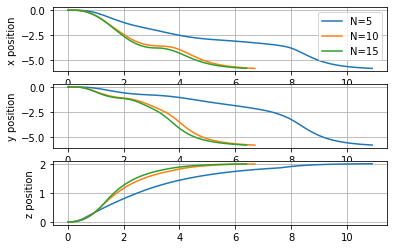

<Figure size 432x288 with 0 Axes>

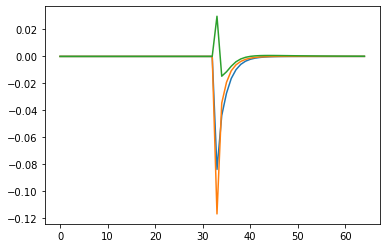

In [18]:
    fig, axs = plt.subplots(3)
    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['x'].shape[0]*0.1-0.01, 0.1)
        axs[0].plot(time_range, real_traj['x'])
        axs[0].set_ylabel('x position')
        axs[0].grid()

    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['y'].shape[0]*0.1-0.01, 0.1)
        axs[1].plot(time_range, real_traj['y'])
        axs[1].set_ylabel('y position')
        axs[1].grid()

    plt.figure(2)
    for real_traj in traj:
        real_traj['x'] = np.array(real_traj['x'], dtype=float)
        real_traj['y'] = np.array(real_traj['y'], dtype=float)
        real_traj['z'] = np.array(real_traj['z'], dtype=float)
        time_range = np.arange(0, real_traj['z'].shape[0]*0.1-0.01, 0.1)
        axs[2].plot(time_range, real_traj['z'])
        axs[2].set_ylabel('z position')
        axs[2].grid()
    axs[0].legend(['N=5','N=10','N=15'])
    
    fig.savefig('time_horizon.pdf')
    plt.show()
    



    
    # plt.figure(3)
    #plt.plot(np.square((np.array(real_trajectory['x'])-np.array(est_trajectory['x'])).reshape(-1,1)))#,axis=1))
    
    # plt.plot(np.array(real_trajectory['z']).reshape(-1,1))#,axis=1))
    # plt.plot(np.array(est_trajectory['z']).reshape(-1,1))
    
    plt.plot(np.array(d_hat_list).reshape(-1,3)-real_disturbance)

In [1]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
from matplotlib import animation
from Quadrotor import Quadrotor_linear

from MPC_controller import mpc_control,mpc_control_stable,OTS,get_observer_gain,luenberger_observer
from visualization import data_for_cylinder_along_z
from convexification import get_intermediate_goal, convexify

np.random.seed(seed=0)
drone = [0,0,0.05]  #pos_x,pos_y,radius
obs1=np.array([-3,1,1])   #pos_x,pos_y,radius
obs2=np.array([-2,-3,1])  #pos_x,pos_y,radius
obs3=np.array([0,2,1]) #pos_x,pos_y,radius
obs4=np.array([-5,-1.9,1]) #pos_x,pos_y,radius
obs5=np.array([0.5,-2,1]) #pos_x,pos_y,radius
#obs6=np.array([-4,-4,1])/1.
obstacle_list=[obs1,obs2,obs3,obs4,obs5]#,obs6]#,obs1*2,obs2*2,obs3*2,obs4*2,obs5*2]

goal = np.array([-5,-5,2]) #pos_x,pos_y,pos_z

sensor_noise_sigma=np.array([0.05,0.05,0.05,0.001,0.001,0.001,0.001,0.001,0.001,0.001])

#sensor_noise_sigma = np.zeros(10)
real_disturbance=np.random.normal(loc=0,scale=0.01,size=3)
print("real _dist", real_disturbance)

Cd= np.zeros((10,3))

Bd= np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [1, 0, 0],
              [0, 1, 0],
              [0, 0, 1],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])


obs_eigen_values= np.array([-0.1, -0.1, -0.1, -0.03, -0.03, -0.03, 0.3, 0.3, 0.6, 0.6, -0.05, -0.05, -0.05])
#obs_eigen_values= np.array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.7, -0.7,-0.7])
def animate(i):
    line.set_xdata(real_trajectory['x'][:i + 1])
    line.set_ydata(real_trajectory['y'][:i + 1])
    line.set_3d_properties(real_trajectory['z'][:i + 1])
    
    line_est.set_xdata(real_trajectory['x'][:i + 1])
    line_est.set_ydata(real_trajectory['y'][:i + 1])
    line_est.set_3d_properties(real_trajectory['z'][:i + 1])
    point.set_xdata(real_trajectory['x'][i])
    point.set_ydata(real_trajectory['y'][i])
    point.set_3d_properties(real_trajectory['z'][i])

if __name__ == "__main__":
    
    N = 10

    quadrotor_linear = Quadrotor_linear()

    x_init = np.zeros(10)
    x_init[0]=drone[0]
    x_init[1]=drone[1]
    
    x_target = np.zeros(10)
    x_target[0] = goal[0]
    x_target[1] = goal[1]
    x_target[2] = goal[2]
    
    x_hat = x_init
    x_real = x_init
    d_hat=np.zeros((3,1))
    output = x_init
    
    L=get_observer_gain(quadrotor_linear, Bd,Cd,obs_eigen_values)
    A,b = convexify(x_init[:2].flatten(),drone[2],obstacle_list)
    
    inter_goal=get_intermediate_goal(x_init[:2].flatten(), 0, x_target[:2].flatten(), A,b).flatten()
    x_intergoal=np.zeros(10)
    x_intergoal[:2]=inter_goal
    x_intergoal[2] = x_target[2]

    real_trajectory = {'x': [], 'y': [], 'z': []}
    est_trajectory = {'x': [], 'y': [], 'z': []}
    output_trajectory = {'x': [], 'y': [], 'z': []}
    
    d_hat_list=[]
    x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A, b, Bd, Cd)

    i = 0
    while np.linalg.norm(x_intergoal[:3].flatten()-x_target[:3]) > 0.1:
        
        i += 1

        A_obs,b_obs=convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
        
        u = mpc_control(quadrotor_linear, N, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A_obs,b_obs)

        if u is None:
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        
        d_hat_list.append(d_hat)
        
        A_obs,b_obs = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)

        x_intergoal[:2] = get_intermediate_goal(output[:2].flatten(), 0,x_target[:2].flatten(), A_obs,b_obs).flatten()
        
        x_ref,u_ref = OTS(quadrotor_linear, x_intergoal, d_hat, A_obs, b_obs, Bd, Cd)

        if x_ref is None :
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))
        #print("x_error:",(x_real).flatten())
        print(i)
        print("x_real :",x_real)
        #print("\n")
        #print("ref:",x_ref,u_ref)
        
    A,b = convexify(x_hat[:2].flatten(),drone[2],obstacle_list)
    print("***")

    while np.linalg.norm(x_real[:3].flatten() - x_target[:3]) >= 0.3 and i<=2000:
        i+=1
        
        output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma)
         
        u = mpc_control_stable(quadrotor_linear, 30, x_hat.flatten(), x_ref.flatten(),u_ref.flatten(),A,b)


        if u is None:
            print("no solution")
            u=np.zeros((4,1))
        else:
            u = u.reshape(-1,1)

        est_trajectory['x'].append(x_hat[0])
        est_trajectory['y'].append(x_hat[1])
        est_trajectory['z'].append(x_hat[2])
        
        real_trajectory['x'].append(x_real[0])
        real_trajectory['y'].append(x_real[1])
        real_trajectory['z'].append(x_real[2])
        
        output_trajectory['x'].append(output[0])
        output_trajectory['y'].append(output[1])
        output_trajectory['z'].append(output[2])
        
        x_real = quadrotor_linear.disturbed_next_x(x_real,u,real_disturbance,Bd)
        
        #output = quadrotor_linear.disturbed_output(x_real,real_disturbance, Cd, sensor_noise_sigma).flatten()
        
        x_hat, d_hat = luenberger_observer(quadrotor_linear, x_hat, d_hat, output, u, Bd, Cd, L)
        d_hat_list.append(d_hat)
        x_ref,u_ref = OTS(quadrotor_linear,x_intergoal,d_hat, A,b,Bd,Cd)

        print(x_hat.flatten())
        
        if x_ref is None :
            x_ref = x_intergoal
            u_ref = np.zeros((4,1))

real _dist [0.01764052 0.00400157 0.00978738]
1
x_real : [[ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.01764052]
 [ 0.00400157]
 [ 0.89755625]
 [ 0.        ]
 [ 0.        ]
 [ 1.52860991]
 [-2.86852041]]
2
x_real : [[ 1.76405235e-03]
 [ 4.00157208e-04]
 [ 8.97556247e-02]
 [ 3.52810469e-02]
 [ 8.00314417e-03]
 [ 1.32889221e+00]
 [ 1.52860991e-01]
 [-2.86852041e-01]
 [ 7.31208023e-01]
 [-1.36948864e+00]]
3
x_real : [[ 5.29215704e-03]
 [ 1.20047163e-03]
 [ 2.22644846e-01]
 [-2.28480281e-01]
 [-1.37951916e-01]
 [ 1.23029778e+00]
 [ 2.25981794e-01]
 [-4.23800904e-01]
 [ 1.02158818e-01]
 [-1.32334982e-01]]
4
x_real : [[-0.01755587]
 [-0.01259472]
 [ 0.34567462]
 [-0.62658844]
 [-0.35563848]
 [ 1.14159625]
 [ 0.23619768]
 [-0.4370344 ]
 [-0.29785239]
 [ 0.39793509]]
5
x_real : [[-0.08021472]
 [-0.04815857]
 [ 0.45983425]
 [-1.03767867]
 [-0.58334683]
 [ 1.09870817]
 [ 0.20641244]
 [-0.39724089]
 [-0.39545043]
 [ 0.78202736]]
6
x_real : [[-0.18398258]
 [-0.10649325]
 [ 0.56970507]
 [-1.409

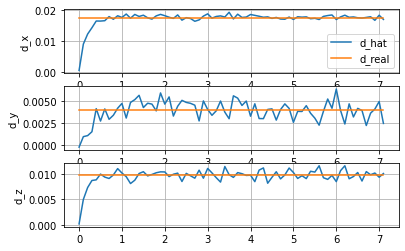

In [14]:
d_hat_list = np.array(d_hat_list).reshape(-1,3)
fig, axs = plt.subplots(3)
time_range = np.arange(0, d_hat_list.shape[0]*0.1-0.01, 0.1)
axs[0].plot(time_range, d_hat_list[:,0], time_range, real_disturbance[0]*np.ones(time_range.shape[0]))
axs[0].grid()
axs[0].set_ylabel('d_x')
axs[1].plot(time_range, d_hat_list[:,1], time_range, real_disturbance[1]*np.ones(time_range.shape[0]))
axs[1].grid()
axs[1].set_ylabel('d_y')
axs[2].plot(time_range, d_hat_list[:,2], time_range, real_disturbance[2]*np.ones(time_range.shape[0]))
axs[2].set_ylabel('d_z')
axs[2].grid()
axs[0].legend(["d_hat","d_real"])
plt.savefig('disturbance.pdf')

plt.show()

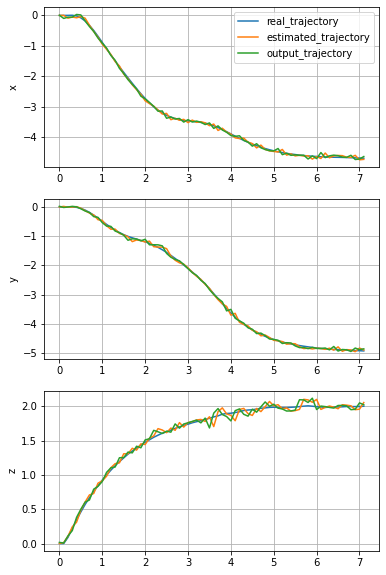

In [20]:
real_trajectory['x'] = np.array(real_trajectory['x'], dtype=float)
real_trajectory['y'] = np.array(real_trajectory['y'], dtype=float)
real_trajectory['z'] = np.array(real_trajectory['z'], dtype=float)

est_trajectory['x'] = np.array(est_trajectory['x'], dtype=float)
est_trajectory['y'] = np.array(est_trajectory['y'], dtype=float)
est_trajectory['z'] = np.array(est_trajectory['z'], dtype=float)

output_trajectory['x'] = np.array(output_trajectory['x'], dtype=float)
output_trajectory['y'] = np.array(output_trajectory['y'], dtype=float)
output_trajectory['z'] = np.array(output_trajectory['z'], dtype=float)

fig, axs = plt.subplots(3, figsize=(6,10))
time_range = np.arange(0, real_trajectory['x'].shape[0]*0.1-0.01, 0.1)

axs[0].plot(time_range, real_trajectory['x'], time_range, est_trajectory['x'], time_range, output_trajectory['x'])
axs[0].grid()
axs[0].set_ylabel('x')
axs[1].plot(time_range, real_trajectory['y'], time_range, est_trajectory['y'], time_range, output_trajectory['y'])
axs[1].grid()
axs[1].set_ylabel('y')
axs[2].plot(time_range, real_trajectory['z'], time_range, est_trajectory['z'], time_range, output_trajectory['z'])
axs[2].grid()
axs[2].set_ylabel('z')
axs[0].legend(["real_trajectory","estimated_trajectory","output_trajectory"])
plt.savefig('observer.pdf')

plt.show()